In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

from os.path import join

from scipy.stats import fligner, t
from nilearn import plotting, datasets, surface
from matplotlib.gridspec import GridSpec

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
morph_pal = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.3, dark=0.2, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal

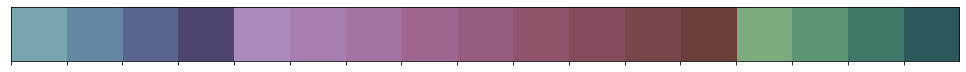

In [3]:
sns.palplot(big_pal)

In [4]:
sns.set(style="white", 
        context="talk", 
        font_scale=0.8,
        rc={"axes.facecolor": (0, 0, 0, 0),
            "font.monospace": 'Courier New',
            "font.family": 'monospace'})
crayons = sns.crayon_palette(['Aquamarine', 'Burnt Sienna', 'Jungle Green', 'Fuchsia', 'Lavender'])

In [5]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [6]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data_qcd.csv"), index_col=0, header=0)

In [7]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [8]:

deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

#morph = img_modalities['smri'].filter(regex='.*vol.*').columns

In [9]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
# separate wm and gm rsi
rsi_gm = list(img_modalities['rsi'].filter(regex='.*gm').columns) + list(img_modalities['rsi'].filter(regex='.*scs').columns)
rsi_wm = list(set(rsi_var) - set(rsi_gm))
rsi_scs = list(img_modalities['rsi'].filter(regex='.*scs').columns)
fmri_var = img_modalities['fmri'].columns
fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

#morph_var = df[df['concept'] == 'macrostructure'].index
#cell_var = df[df['concept'] == 'microstructure'].index
func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [10]:
imaging_apd = list(deltasmri_complete.columns) + list(deltadti_complete.columns) + list(deltarsi_complete.columns) + list(deltarsfmri_complete.columns)

In [11]:
concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd',
                     'dtild', 
                     'dtitd'],
            'func':['var',
                    'c',
                    'cor',
                    #'subcortical-network fc'
                   ]}

In [12]:
# need to calculate mean & sd for each imaging variable change score
descriptives = pd.DataFrame(columns=['annualized percent change', 'sdev', 'concept', 'atlas', 'measure'])
for var in imaging_apd:
    descriptives.at[var,'annualized percent change'] = df[var].mean()
    descriptives.at[var,'sdev'] = df[var].std()
    if 'mrisdp' in var:
        var_num = int(var.split('.')[0].split('_')[-1])
        descriptives.at[var, 'atlas'] = 'dtx'
        if var_num <= 148:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'thick'
        elif var_num <= 450 and var_num >= 303:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'area'
        elif var_num < 604 and var_num >= 450:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'vol'
        elif var_num <= 1054 and var_num >= 907:
            descriptives.at[var, 'concept'] = 'cellular architecture'
            descriptives.at[var, 'measure'] = 't1wcnt'
        elif var_num == 604:
            descriptives.at[var, 'concept'] = 'macrostructure'
            descriptives.at[var, 'measure'] = 'vol'
    elif '_' in var:
        var_list = var.split('.')[0].split('_')
        descriptives.at[var, 'measure'] = var_list[1]
        descriptives.at[var, 'atlas'] = var_list[2]
        if var_list[1] in concepts['morph']:
            descriptives.at[var, 'concept'] = 'macrostructure'
        elif var_list[1] in concepts['cell']:
            descriptives.at[var, 'concept'] = 'cellular architecture'
        if var_list[1] in concepts['func']:
            descriptives.at[var, 'concept'] = 'function'
        if var in btwn_fc:
            descriptives.at[var, 'measure'] = 'between-network fc'
        elif var in wthn_fc:
            descriptives.at[var, 'measure'] = 'within-network fc'
        elif var in fc_scor_var:
            descriptives.at[var, 'measure'] = 'subcortical-network fc'
        elif var in rsi_scs:
            if 'rsirni' in var:
                descriptives.at[var, 'measure'] = 'rsirnigm'
            elif 'rsirnd' in var:
                descriptives.at[var, 'measure'] = 'rsirndgm'
            

In [13]:
descriptives['variance'] = descriptives['sdev'] ** 2

In [26]:
sub_df['variance']

,annualized percent change,sdev,concept,atlas,measure,variance
smri_area_cdk_banksstslh.change_score,-0.329258,2.782295,macrostructure,cdk,Cortical Area,7.741163
smri_area_cdk_cdacatelh.change_score,0.724602,2.611420,macrostructure,cdk,Cortical Area,6.819512
smri_area_cdk_cdmdfrlh.change_score,0.185836,2.766865,macrostructure,cdk,Cortical Area,7.655543
smri_area_cdk_cuneuslh.change_score,0.016584,1.771285,macrostructure,cdk,Cortical Area,3.137450
smri_area_cdk_ehinallh.change_score,0.546391,5.415478,macrostructure,cdk,Cortical Area,29.327405
...,...,...,...,...,...,...
dmri_rsirndgm_cdk_smrh.change_score,-0.904376,4.689442,cellular architecture,cdk,GM RND,21.990863
dmri_rsirndgm_cdk_fprh.change_score,-1.586043,8.625922,cellular architecture,cdk,GM RND,74.406530
dmri_rsirndgm_cdk_tprh.change_score,-0.350867,6.490013,cellular architecture,cdk,GM RND,42.120273
dmri_rsirndgm_cdk_ttrh.change_score,-1.488407,7.323366,cellular architecture,cdk,GM RND,53.631692


In [14]:
#descriptives.to_csv(join(PROJ_DIR, OUTP_DIR, 'apchange_descriptives-all_regions.csv'))

In [15]:
drop = ['dtx', 'meanmotion',
       'subthreshnvols', 'subtcignvols', 'ntpoints']
drop_var = []
for var in drop:
    drop_var += list(descriptives[descriptives['atlas'] == var].index)

In [16]:
descriptives.drop(list(drop_var), axis=0, inplace=True)

In [17]:
measures = list(descriptives['measure'].unique())
concepts = ['macrostructure', 'microstructure', 'function']

In [30]:
long_names = {'var': 'BOLD Variance',
              'between-network fc': 'Between FC',
              'within-network fc': 'Within FC',
              'subcortical-network fc': 'Subcortical FC',
              'dtivol': 'WM Volume',
              'vol': 'GM Volume',
              'thick': 'CT',
              'area': 'CA',
              'dtifa': 'WM FA',
              'dtimd': 'WM MD',
              'dtild': 'WM LD',
              'dtitd': 'WM TD',
              'rsirni': 'WM RNI',
              'rsirnd': 'WM RND',
              'rsirnigm': 'GM RNI',
              'rsirndgm': 'GM RND',
              't1wcnt': 'GM/WM'}

In [45]:
sub_df = descriptives[descriptives['concept'] == 'macrostructure']
sub2_df = descriptives[descriptives['concept'] == 'cellular architecture']
sub_df = pd.concat([sub_df, sub2_df])
sub_df.replace(long_names, inplace=True)

In [48]:
sub_df.max()

annualized percent change          3.445335
sdev                               9.769841
concept                      macrostructure
atlas                                   scs
measure                           WM Volume
variance                           95.44979
dtype: object

In [46]:
morph_cell_pal = morph_pal + cell_pal

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._f

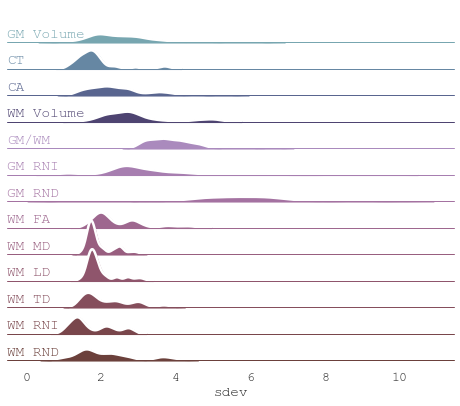

In [49]:
g = sns.FacetGrid(sub_df, 
                  row="measure", row_order=['GM Volume', 'CT', 'CA', 
                                            'WM Volume', 'GM/WM','GM RNI', 'GM RND', 
                                            'WM FA',
                                            'WM MD', 'WM LD', 'WM TD',
                                            'WM RNI', 
                                            'WM RND',
                                            ],
                  hue="measure", hue_order=['GM Volume', 'CT', 'CA', 
                                            'WM Volume', 'GM/WM','GM RNI', 'GM RND', 
                                            'WM FA',
                                            'WM MD', 'WM LD', 'WM TD',
                                            'WM RNI', 
                                            'WM RND'],
                  aspect=16, 
                  height=.5, 
                  palette=morph_cell_pal,
                  #xlim=(-3,4)
                 )

# Draw the densities in a few steps
g.map(sns.kdeplot, "sdev",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "sdev", clip_on=False, color="w", lw=2.5, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    #ax.set_xscale('log')
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "sdev")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")

g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_morpcell-variance.png', dpi=400, bbox_inches='tight')

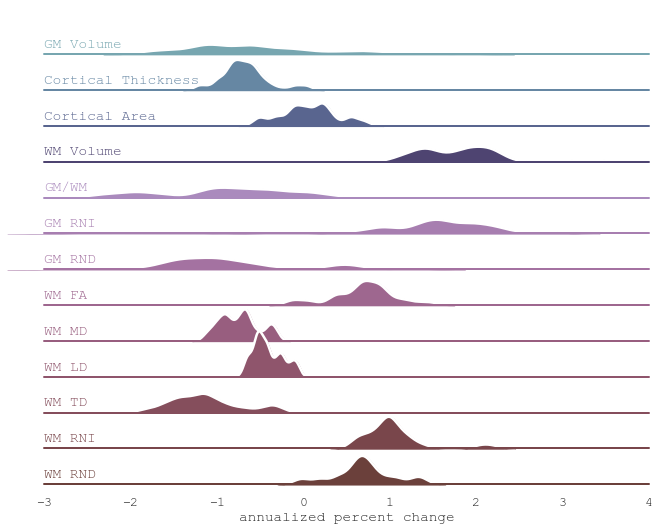

In [63]:
g = sns.FacetGrid(sub_df, 
                  row="measure", row_order=['GM Volume', 'Cortical Thickness', 'Cortical Area', 
                                            'WM Volume', 'GM/WM','GM RNI', 'GM RND', 
                                            'WM FA',
                                            'WM MD', 'WM LD', 'WM TD',
                                            'WM RNI', 
                                            'WM RND',
                                            ],
                  hue="measure", hue_order=['GM Volume', 'Cortical Thickness', 'Cortical Area', 
                                            'WM Volume', 'GM/WM','GM RNI', 'GM RND', 
                                            'WM FA',
                                            'WM MD', 'WM LD', 'WM TD',
                                            'WM RNI', 
                                            'WM RND'],
                  aspect=16, 
                  height=.6, 
                  palette=morph_cell_pal,
                  xlim=(-3,4))

# Draw the densities in a few steps
g.map(sns.kdeplot, "annualized percent change",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "annualized percent change", clip_on=False, color="w", lw=2.5, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, #fontweight="bold", 
            color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "annualized percent change")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_morpcell.png', dpi=400)

In [51]:
sub_df = descriptives[descriptives['concept'] == 'function']
sub_df2 = descriptives[descriptives['concept'] == 'function']
sub_df.replace(long_names, inplace=True)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_4391/1620986697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.replace(long_names, inplace=True)


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._f

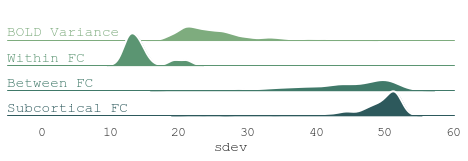

In [52]:
g = sns.FacetGrid(sub_df, row="measure", hue="measure", aspect=16, height=0.5, palette=func_pal, xlim=(-5, 60)
                 )

# Draw the densities in a few steps
g.map(sns.kdeplot, "sdev",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "sdev", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "sdev")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.savefig(f'../{FIGS_DIR}/apr_function-variance.png', dpi=400)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._f

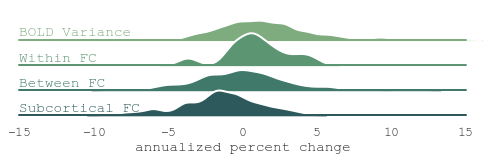

In [24]:
g = sns.FacetGrid(sub_df, row="measure", hue="measure", aspect=16, height=0.5, palette=func_pal, xlim=(-15, 15))

# Draw the densities in a few steps
g.map(sns.kdeplot, "annualized percent change",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "annualized percent change", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "annualized percent change")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
#g.savefig(f'../{FIGS_DIR}/apr_function.png', dpi=400)

In [25]:
desc_summ = pd.DataFrame(index=measures, columns=['mean', 'sdev', '95%CI'])
for measure in measures:
    temp_df = descriptives[descriptives['measure'] == measure]
    mean = np.mean(temp_df['annualized percent change'])
    desc_summ.at[measure, 'mean'] = np.round(mean,2)
    sdev = np.mean(temp_df['sdev'])
    desc_summ.at[measure, 'sdev'] = np.round(sdev,2)
    dof = len(temp_df.index)-1 
    confidence = 0.95
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    CI = (np.round(mean - sdev *t_crit / np.sqrt(dof + 1), 2), np.round(mean + sdev * t_crit / np.sqrt(dof + 1),2)) 
    desc_summ.at[measure, '95%CI'] = CI

In [26]:
#desc_summ.to_csv(join(PROJ_DIR, OUTP_DIR, 'apchange_descriptives.csv'))

In [27]:
# let's visualize APD!
destrieux = datasets.fetch_atlas_destrieux_2009()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')

Reading local neurovault data.
Already fetched 1 image
1 image found on local disk.


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [28]:
def plot_surfaces(nifti, surf, cmap, vmax, threshold):
    '''
    Plots of medial and lateral left and right surface views from nifti volume
    '''
    
    texture_l = surface.vol_to_surf(nifti, surf.pial_left, interpolation='nearest')
    texture_r = surface.vol_to_surf(nifti, surf.pial_right, interpolation='nearest')
    
    fig = plt.figure(figsize=(12,4))
    gs = GridSpec(1, 4)

    ax0 = fig.add_subplot(gs[0], projection='3d')
    ax1 = fig.add_subplot(gs[1], projection='3d')
    ax2 = fig.add_subplot(gs[2], projection='3d')
    ax3 = fig.add_subplot(gs[3], projection='3d')
    plt.tight_layout(w_pad=-1, h_pad=-1)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax0)
    figure = plotting.plot_surf_stat_map(surf.pial_left, 
                                         texture_l, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax1)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,
                                         cmap=cmap, 
                                         view='lateral', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax2)
    figure = plotting.plot_surf_stat_map(surf.pial_right, 
                                         texture_r, 
                                         symmetric_cbar=False, 
                                         threshold=threshold,     
                                         cmap=cmap, 
                                         view='medial', 
                                         colorbar=False, 
                                         vmax=vmax, 
                                         axes=ax3)
    return figure

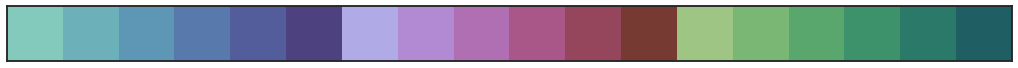

In [29]:
morph_pal = sns.cubehelix_palette(start=0.6, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=1, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(start=1.7, rot=-0.8, gamma=1.0, hue=1, light=0.7, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=9, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.5, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(start=3.0, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.2, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal
sns.palplot(big_pal)

In [30]:
nifti_mapping = pd.read_csv(join(PROJ_DIR, 
                                 DATA_DIR, 
                                 'variable_to_nifti_mapping.csv'), 
                            header=0, 
                            index_col=0)

In [31]:
# list of measures to plot
measures = {'cortical-thickness': 'smri_thick_cdk_.*change_score',
            'cortical-gwcontrast': 'smri_t1wcnt_cdk_.*change_score',
            'cortical-area': 'smri_area_cdk_.*change_score',
            'cortical-volume': 'smri_vol_cdk_.*change_score', 
            'subcortical-volume': 'smri_vol_scs_.*change_score', 
            'subcortical-RND': 'dmri_rsirnd_scs_.*change_score',
            'subcortical-RNI': 'dmri_rsirni_scs_.*change_score',
            'cortical-RND': 'dmri_rsirndgm_.*change_score',
            'cortical-RNI': 'dmri_rsirnigm_.*change_score',
            'cortical-BOLD-variance': 'rsfmri_var_cdk_.*change_score',
            'tract-volume': 'dmri_dtivol.*', 
            'tract-FA': 'dmri_dtifa_fiberat_.*', 
            'tract-MD': 'dmri_dtimd_fiberat_.*',
            'tract-LD': 'dmri_dtild_fiberat_.*', 
            'tract-TD': 'dmri_dtitd_fiberat_.*', 
            'tract-RND': 'dmri_rsirnd_fib_.*',
            'tract-RNI': 'dmri_rsirni_fib_.*'}

conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*change_score',
            'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*change_score',}

In [32]:
fsaverage = datasets.fetch_surf_fsaverage()

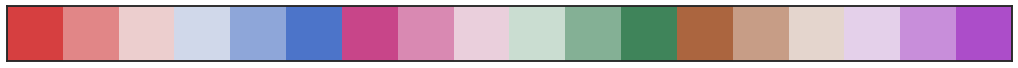

In [33]:
morph_cmap = sns.diverging_palette(12, 256.3, s=70, l=50, center="light", as_cmap=True)
func_cmap = sns.diverging_palette(343, 140.9, s=70, l=50, center="light", as_cmap=True)
cell_cmap = sns.diverging_palette(31, 294.3, s=70, l=50, center="light", as_cmap=True)
morph_pal = sns.diverging_palette(12, 256.3, s=70, l=50, center="light", as_cmap=False)
func_pal = sns.diverging_palette(343, 140.9, s=70, l=50, center="light", as_cmap=False)
cell_pal = sns.diverging_palette(31.0, 294.3, s=70, l=50, center="light", as_cmap=False)
sns.palplot(morph_pal + func_pal + cell_pal)

pals = {'cortical-thickness': morph_cmap,
        'cortical-gwcontrast': cell_cmap,
            'cortical-area': morph_cmap,
            'cortical-volume': morph_cmap, 
            'subcortical-volume': morph_cmap, 
            'subcortical-RND': cell_cmap,
            'subcortical-RNI': cell_cmap,
            'cortical-RND': cell_cmap,
            'cortical-RNI': cell_cmap,
            'cortical-BOLD-variance': func_cmap,
            'tract-volume': morph_cmap, 
            'tract-FA': cell_cmap, 
            'tract-MD': cell_cmap,
            'tract-LD': cell_cmap, 
            'tract-TD': cell_cmap,
            'tract-RND': cell_cmap,
            'tract-RNI': cell_cmap,
        'cortical-network-connectivity': func_cmap,
            'subcortical-network-connectivity': func_cmap}

cortical-thickness
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
cortical-gwcontrast
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
cortical-area
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
cortical-volume
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
subcortical-volume
/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/resources/harvox-subcortical-maxprob-thr50-2mm.nii


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


subcortical-RND
/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/resources/harvox-subcortical-maxprob-thr50-2mm.nii
subcortical-RNI
/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/resources/harvox-subcortical-maxprob-thr50-2mm.nii
cortical-RND
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
cortical-RNI
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
cortical-BOLD-variance
/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
tract-volume
/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/ABCD_Outcomes/ABCD-brain outcomes/AtlasTrack/fibertract_visualization/ABCD Atlas Track ROIs/fiber_101_mni.nii.gz
tract-FA
/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/ABCD_Outcomes/ABCD-brain outcomes/AtlasTrack/fibertract_visualization/ABCD Atlas Track ROIs/fiber_101_mni.nii.gz
tract-MD
/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/ABCD_Outcomes/ABCD-brain outcomes/AtlasT

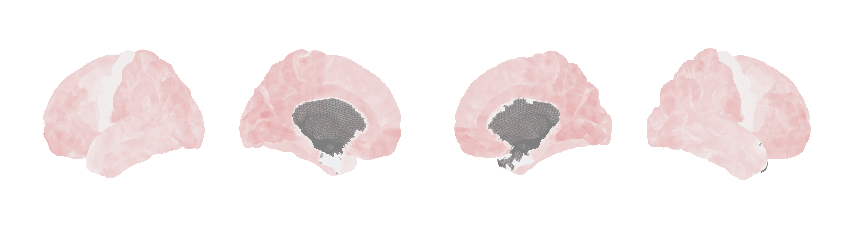

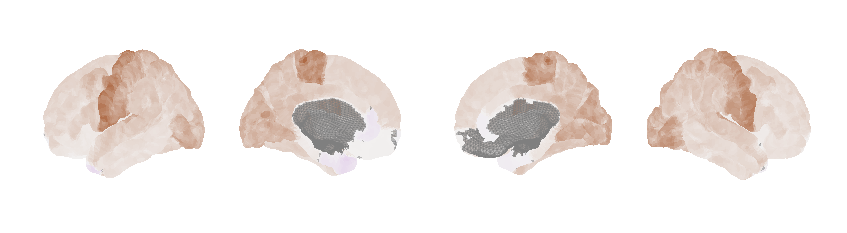

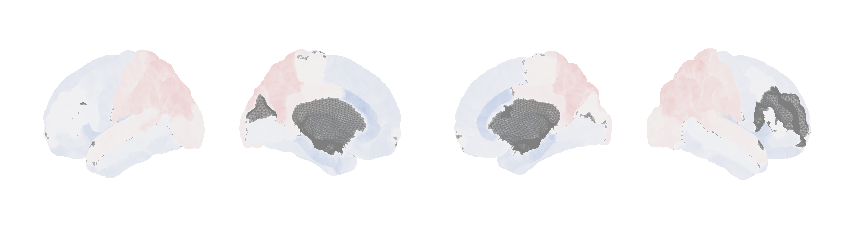

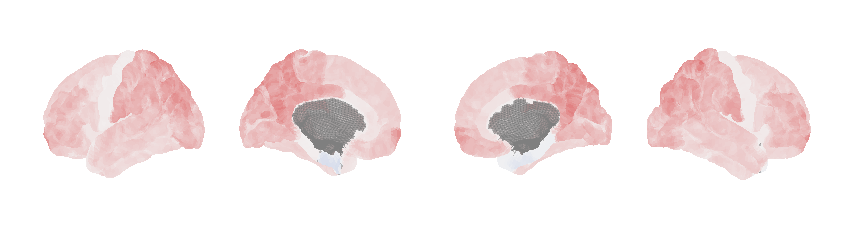

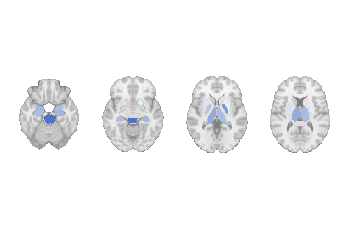

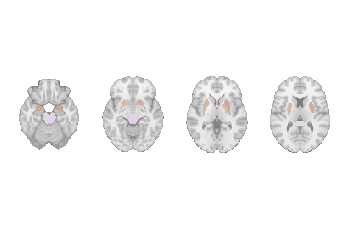

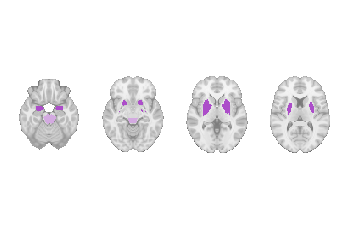

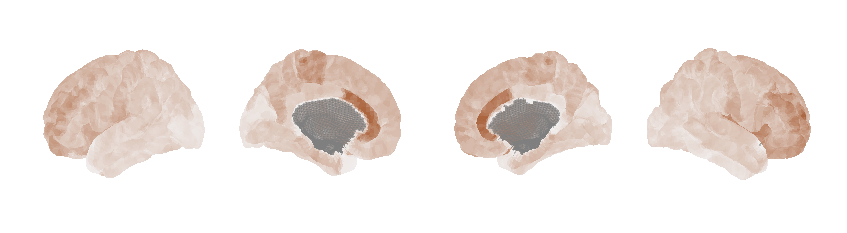

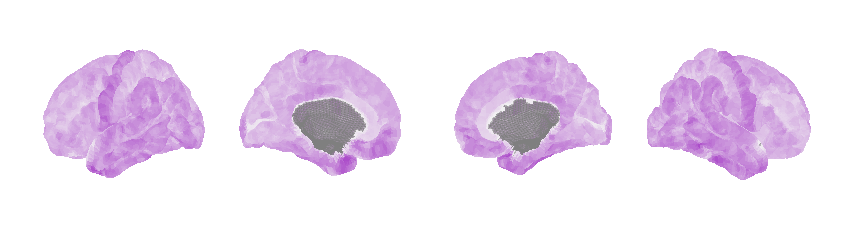

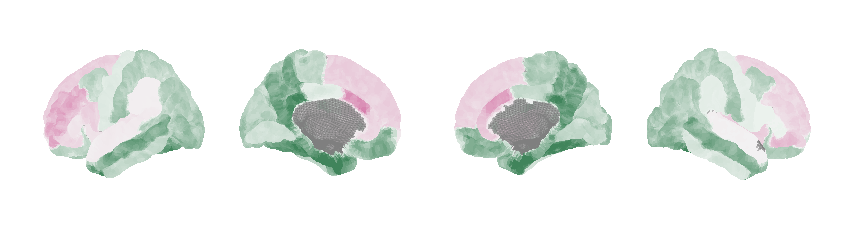

In [34]:
# let's plot APC on brains pls
for measure in measures:
    if 'BOLD' in measure:
        vmax = 3.5
    else: 
        vmax = 1.5
    print(measure)
    meas_df = descriptives.filter(regex=measures[measure], axis=0)
    meas_vars = [i.split('.')[0] for i in meas_df.index]
    #print(nifti_mapping.loc[meas_vars]['atlas_fname'])
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    if 'tract' in measure:
        fibers = nifti_mapping.filter(regex=measures[measure], axis=0).index
        var = fibers[0]
        tract_fname = nifti_mapping.loc[var]['atlas_fname']
        tract_nii = nib.load(tract_fname)
        tract_arr = tract_nii.get_fdata()
        #print(np.unique(tract_arr))
        avg = descriptives.at[f'{var}.change_score', 'annualized percent change']
        tract_arr *= avg
        all_tracts_arr = np.zeros(tract_arr.shape)
        all_tracts_arr += tract_arr
        for var in fibers[1:]:    
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            if type(tract_fname) is str:
                try:
                    tract_nii = nib.load(tract_fname)
                    tract_arr = tract_nii.get_fdata()
                    #print(np.unique(tract_arr))
                    avg = descriptives.at[f'{var}.change_score', 'annualized percent change']
                    tract_arr *= avg
                    all_tracts_arr += tract_arr
                except Exception as e:
                    pass
            else:
                pass
        meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
        #plt.figure(layout='tight')
        #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_anat(meas_nimg, display_mode='z',  threshold=0.01,
                            cut_coords=[35,50,65,85], 
                            black_bg=False,
                                vmax=vmax*1.1, 
                                vmin=-vmax*1.1,
                                annotate=False, cmap=pals[measure], colorbar=False,
                                #axes=ax[0]
                            )
        q.close()
        #q.savefig(f'{PROJ_DIR}/figures/APC_{measure}.png', dpi=400)
        q = None
    else:
        for i in meas_df.index:
            j = i.split('.')[0]
            value = nifti_mapping.loc[j]['atlas_value']
            #print(i, value)
            if value is np.nan:
                pass
            else:
                avg = descriptives.at[i, 'annualized percent change']
                plotting_arr[np.where(atlas_arr == value)] = avg
        meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
        if 'subcortical' in measure:
            fig,ax = plt.subplots()
            #plt.figure(layout='tight')
            q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=0.01,
                                   cut_coords=[-20, -10, 0, 10], vmax=vmax*1.1, 
                                   annotate=False, cmap=pals[measure], colorbar=False,
                                   symmetric_cbar=False, axes=ax)

            q.savefig(f'{PROJ_DIR}/figures/APC_{measure}.png', dpi=400)
        elif 'cortical' in measure:
            figure = plot_surfaces(meas_nimg, fsaverage, pals[measure], vmax, 0.01)
            #figure.savefig(f'{PROJ_DIR}/figures/APC_{measure}.png', dpi=400, bbox_inches='tight')

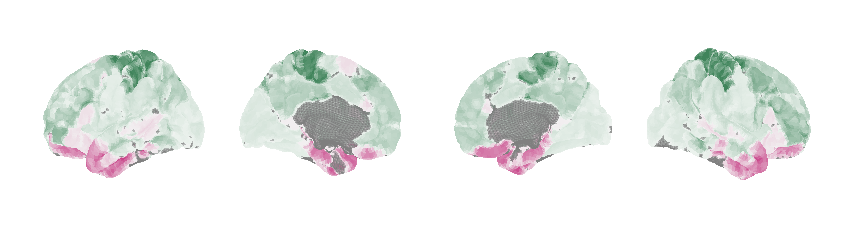

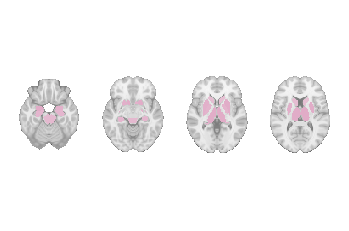

<Figure size 432x288 with 0 Axes>

In [35]:
corrs = descriptives.filter(regex='rsfmri_c_ngd.*', axis=0).index
corrs = [i.split('.')[0] for i in corrs]
networks = list(np.unique([i.split('_')[-1] for i in corrs]))

corrs = descriptives.filter(regex='rsfmri_c_ngd.*', axis=0).index
corrs = [i.split('.')[0] for i in corrs]
networks = list(np.unique([i.split('_')[-1] for i in corrs]))

btwn_fc_src = [i.split('.')[0].split('_')[3] for i in btwn_fc]
btwn_fc_trgt = [i.split('.')[0].split('_')[-1] for i in btwn_fc]

vmax = 3.5

# okay, now we're plotting between and within network connectivity
#within-network fc is easy to plot bc there's only one HSK value per network (per fligner_var)
meas_df = descriptives.loc[wthn_fc]
meas_vars = [i.split('.')[0] for i in meas_df.index]
atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
#print(atlas_fname)
atlas_nii = nib.load(atlas_fname)
atlas_arr = atlas_nii.get_fdata()
plotting_arr = np.zeros(atlas_arr.shape)
for i in meas_df.index:
    j = i.split('.')[0]
    value = nifti_mapping.loc[j]['atlas_value']
    #print(i, value)
    if value is np.nan:
        pass
    else:
        plotting_arr[np.where(atlas_arr == value)] = descriptives.at[i,'annualized percent change']

meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
figure = plot_surfaces(meas_nimg, fsaverage, func_cmap, vmax, .01)
#figure.savefig(f'{PROJ_DIR}/figures/APCxFCw.png', dpi=400)

fc_scor_var
scs_varnames = [i.split('.')[0].split('_')[-1] for i in fc_scor_var]


# now subcortical-cortical functional connectivity
sig = []
meas_df = descriptives.loc[fc_scor_var]

meas_df.loc[fc_scor_var, 'scs'] = scs_varnames
avgs = pd.DataFrame()
for scs in np.unique(scs_varnames):
    temp_df = meas_df[meas_df['scs'] == scs]
    # calculate average APC of all 

    for i in temp_df.index:
        sig.append(temp_df.loc[i,'annualized percent change'])
    mean_apc = np.mean(sig)
    #print(mean_hsk)
    # grab name of first conn var for this network for plotting
    avgs.at[temp_df.index[0], 'apc'] = mean_apc
#print(nsig)
meas_vars = [i.split('.')[0] for i in avgs.index]
atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
#print(atlas_fname)
atlas_nii = nib.load(atlas_fname)
atlas_arr = atlas_nii.get_fdata()
plotting_arr = np.zeros(atlas_arr.shape)
sig = 0
for i in avgs.index:
    j = i.split('.')[0]
    value = nifti_mapping.loc[j]['atlas_value']
    #print(i, value)
    if value is np.nan:
        pass
    else:
        plotting_arr[np.where(atlas_arr == value)] = avgs.at[i,'apc']        
meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
fig,ax = plt.subplots(#ncols=2, gridspec_kw=grid_kw, figsize=(24,4)
                     )
plt.figure(layout='tight')
q = plotting.plot_stat_map(meas_nimg, display_mode='z',  #threshold=.01,
                       cut_coords=[-20, -10, 0, 10], vmax=vmax*1.1, 
                       annotate=False, cmap=func_cmap, colorbar=False,
                       symmetric_cbar=False, axes=ax)

#ax[1].set_visible(False)
#q.savefig(f'{PROJ_DIR}/figures/APCxFCs_scs.png', dpi=400)

ad
ca
cgc
dla
dt
fo
n
rspltp
sa
smh
smm
vs
vta
383312
80475
1123790
768286
1544315
551460
855684
159817
48859
888729
300742
1154383
443618


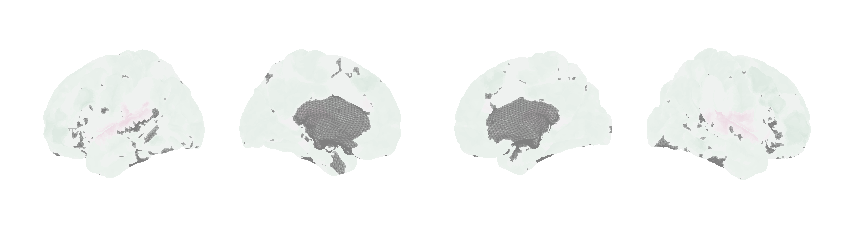

In [36]:
# between-network FC is tough bc we have to average all of a networks HSK values
# but only the significantly HSK connections
sig = []
meas_df = descriptives.loc[btwn_fc]
meas_df.loc[btwn_fc, 'from_ntwk'] = btwn_fc_src
meas_df.loc[btwn_fc, 'to_ntwk'] = btwn_fc_trgt
avgs = pd.DataFrame()
ntwks = btwn_fc_src + ['vs']
for ntwk in np.unique(ntwks):
    print(ntwk)
    temp_df = meas_df[meas_df['from_ntwk'] == ntwk]
    temp_df2 = meas_df[meas_df['to_ntwk'] == ntwk]
    temp_df = pd.concat([temp_df, temp_df2], axis=0)
    # calculate average heteroscedasticity of all 
    # significantly heteroscedastic network connections
    for i in temp_df.index:
        sig.append(temp_df.loc[i,'annualized percent change'])
    mean_hsk = np.mean(sig)
    # grab name of first conn var for this network for plotting
    avgs.at[temp_df.index[0], 'apc'] = mean_hsk
meas_vars = [i.split('.')[0] for i in avgs.index]
atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
#print(atlas_fname)
atlas_nii = nib.load(atlas_fname)
atlas_arr = atlas_nii.get_fdata()
plotting_arr = np.zeros(atlas_arr.shape)
sig = 0
for i in avgs.index:
    if not 'vs.' in i:
        j = i.split('.')[0]
    elif not 'vta' in i:
        j = 'rsfmri_c_ngd_vs_ngd_vs'
    else: 
        j = i.split('.')[0]  
    value = nifti_mapping.loc[j]['atlas_value']
    #print(i,j,'\t', value,'\t', avgs.at[i,'apc'])
    if value is np.nan:
        pass
    else:
        print(sum(sum(np.where(atlas_arr == value))))
        plotting_arr[np.where(atlas_arr == value)] = avgs.at[i,'apc']        
meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
figure = plot_surfaces(meas_nimg, fsaverage, func_cmap, vmax, 0.001)
figure.savefig(f'{PROJ_DIR}/figures/APCxFCb.png', dpi=400)

In [37]:
for ntwk in np.unique(ntwks):
    temp_df = meas_df[meas_df['from_ntwk'] == ntwk]
    temp_df2 = meas_df[meas_df['to_ntwk'] == ntwk]
    temp_df = pd.concat([temp_df, temp_df2], axis=0)
    print(temp_df.index, temp_df.columns)
    help
    conn_arr = np.zeros(atlas_arr.shape)
    for i in temp_df.index:
        if not 'vs.' in i:
            j = i.split('.')[0]
        elif not 'vta' in i:
            j = 'rsfmri_c_ngd_vs_ngd_vs'
        else: 
            j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        
        #print(i, value)
        if value is np.nan:
            pass
        else:
            plotting_arr[np.where(atlas_arr == value)] = temp_df.loc[i]['annualized percent change']

Index(['rsfmri_c_ngd_ad_ngd_cgc.change_score',
       'rsfmri_c_ngd_ad_ngd_ca.change_score',
       'rsfmri_c_ngd_ad_ngd_dt.change_score',
       'rsfmri_c_ngd_ad_ngd_dla.change_score',
       'rsfmri_c_ngd_ad_ngd_fo.change_score',
       'rsfmri_c_ngd_ad_ngd_n.change_score',
       'rsfmri_c_ngd_ad_ngd_rspltp.change_score',
       'rsfmri_c_ngd_ad_ngd_smh.change_score',
       'rsfmri_c_ngd_ad_ngd_smm.change_score',
       'rsfmri_c_ngd_ad_ngd_sa.change_score',
       'rsfmri_c_ngd_ad_ngd_vta.change_score',
       'rsfmri_c_ngd_ad_ngd_vs.change_score'],
      dtype='object') Index(['annualized percent change', 'sdev', 'concept', 'atlas', 'measure',
       'from_ntwk', 'to_ntwk'],
      dtype='object')
Index(['rsfmri_c_ngd_ca_ngd_dt.change_score',
       'rsfmri_c_ngd_ca_ngd_dla.change_score',
       'rsfmri_c_ngd_ca_ngd_fo.change_score',
       'rsfmri_c_ngd_ca_ngd_n.change_score',
       'rsfmri_c_ngd_ca_ngd_rspltp.change_score',
       'rsfmri_c_ngd_ca_ngd_smh.change_score',
       

Index(['rsfmri_c_ngd_vta_ngd_vs.change_score',
       'rsfmri_c_ngd_ad_ngd_vta.change_score',
       'rsfmri_c_ngd_cgc_ngd_vta.change_score',
       'rsfmri_c_ngd_ca_ngd_vta.change_score',
       'rsfmri_c_ngd_dt_ngd_vta.change_score',
       'rsfmri_c_ngd_dla_ngd_vta.change_score',
       'rsfmri_c_ngd_fo_ngd_vta.change_score',
       'rsfmri_c_ngd_n_ngd_vta.change_score',
       'rsfmri_c_ngd_rspltp_ngd_vta.change_score',
       'rsfmri_c_ngd_smh_ngd_vta.change_score',
       'rsfmri_c_ngd_smm_ngd_vta.change_score',
       'rsfmri_c_ngd_sa_ngd_vta.change_score'],
      dtype='object') Index(['annualized percent change', 'sdev', 'concept', 'atlas', 'measure',
       'from_ntwk', 'to_ntwk'],
      dtype='object')


In [38]:
# consider plotting between-FC per network... for the supplement?

Text(0.5, 0, 'Annualized percent change')

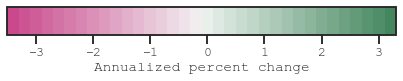

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl

morph_cmap = sns.diverging_palette(12, 256.3, s=70, l=50, center="light", n=6, as_cmap=True)
func_cmap = sns.diverging_palette(343, 140.9, s=70, l=50, center="light", n=6, as_cmap=True)
cell_cmap = sns.diverging_palette(31, 294.3, s=70, l=50, center="light", n=6, as_cmap=True)


fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

vmax = 1.5
range_ = np.arange(-int(vmax*5), int(vmax*5)) / 5.

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=morph_cmap, 
                               values=range_, 
                              )
ax.set_xlabel('Annualized percent change')

#plt.savefig(f'{PROJ_DIR}/figures/morph-cmap_1-{-vmax,vmax}.png', bbox_inches='tight', dpi=400)

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=cell_cmap, 
                               values=range_, 
                              )
ax.set_xlabel('Annualized percent change')
#plt.savefig(f'{PROJ_DIR}/figures/cell-cmap_1-{-vmax,vmax}.png', bbox_inches='tight', dpi=400)

vmax = 3.5
range_ = np.arange(-int(vmax*5), int(vmax*5)) / 5.

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=func_cmap, 
                               values=range_, 
                              )
ax.set_xlabel('Annualized percent change')
#plt.savefig(f'{PROJ_DIR}/figures/func-cmap_1-{-vmax,vmax}.png', bbox_inches='tight', dpi=400)